# CSE 572: Homework 4

This notebook provides a template and starting code to implement the Homework 4 assignment.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Problem statement

In Lab 18, we used statistical and distance-based approaches to detect anomalous changes in the daily closing prices of various stocks. The input data stocks.csv contains the historical closing prices of stocks for 3 large corporations (Microsoft, Ford Motor Company, and Bank of America). In the lab, we used anomaly detection techniques to detect anomalies in the changes in daily closing prices over the entire dataset (entire time period). 

In this homework, you will re-frame this problem as novelty detection. Instead of scoring each sample based on its anomalousness compared to all other samples, you will score every sample based on its anomalousness compared to all previous samples in time. You will step through each record in order of time and at each step construct an updated model that will be used to score the new sample. Use the kth nearest neighbor approach used in Lab 18, but instead of using the distance to the 4th nearest neighbor as in Lab 18, use the average distance to the five nearest neighbors. 

## Load the dataset

In [1]:
import pandas as pd

stocks = pd.read_csv('https://docs.google.com/uc?export=download&id=1UqHZmlfSoPDcZlTIr2TB6OadBhni9Kbv', header='infer')
stocks

stocks.index = stocks['Date']
stocks = stocks.drop(['Date'], axis=1)
stocks.head()

,MSFT,F,BAC
Date,,,
1/3/2007,29.860001,7.51,53.330002
1/4/2007,29.809999,7.70,53.669998
1/5/2007,29.639999,7.62,53.240002
1/8/2007,29.930000,7.73,53.450001
1/9/2007,29.959999,7.79,53.500000


We can compute the percentage of changes in the daily closing price of each stock as follows:
\begin{equation}
\Delta(t) = 100 \times \frac{x_t - x_{t-1}}{x_{t-1}} 
\end{equation}

where $x_t$ denotes the price of a stock on day $t$ and $x_{t-1}$ denotes the price on its previous day, $t-1$.

In [2]:
import numpy as np

N, d = stocks.shape

delta = pd.DataFrame(100*np.divide(stocks.iloc[1:,:].values-stocks.iloc[:N-1,:].values, stocks.iloc[:N-1,:].values),
                     columns=stocks.columns, 
                     index=stocks.iloc[1:].index)

delta.head()

,MSFT,F,BAC
Date,,,
1/4/2007,-0.167455,2.529960,0.637532
1/5/2007,-0.570278,-1.038961,-0.801185
1/8/2007,0.978411,1.443570,0.394438
1/9/2007,0.100231,0.776197,0.093543
1/10/2007,-1.001332,-0.770218,0.149536


## Compute novelty scores

In this section, you will:
- Plot the novelty scores over time
- Identify which dates had the 5 highest novelty scores 

In [3]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
novelty_scores = [0]
k_neearest_neightbours = 5
for i in range(1, delta.shape[0]):

    past_data = delta.iloc[:i].to_numpy()
    current_data = np.expand_dims(delta.iloc[i].to_numpy(), axis=0)

    if k_neearest_neightbours > past_data.shape[0]:
        neighbors = NearestNeighbors(n_neighbors=past_data.shape[0], metric=distance.euclidean).fit(past_data)
    else:
        neighbors = NearestNeighbors(n_neighbors=k_neearest_neightbours, metric=distance.euclidean).fit(past_data)

    distances, indices = neighbors.kneighbors(current_data)
    novelty_scores.append(np.mean(distances))
delta['novelty'] = novelty_scores

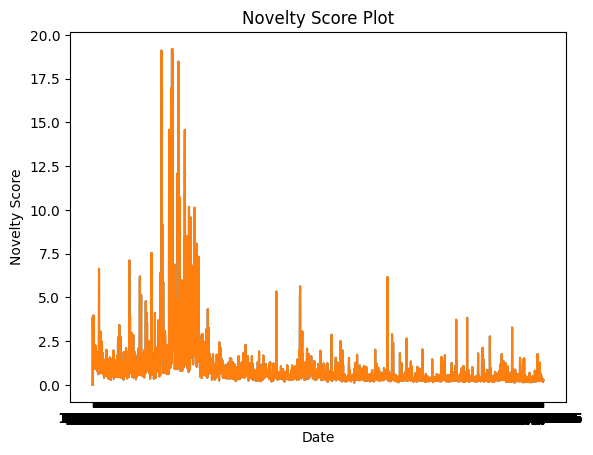

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)

ax.plot(delta['novelty'])


ax.set_ylabel('Novelty Score')
ax.set_title('Novelty Score Plot')
delta['novelty'].plot(ax=ax)


plt.show()



In [5]:
delta.nlargest(5, 'novelty')

,MSFT,F,BAC,novelty
Date,,,,
10/7/2008,-6.744279,-20.867209,-26.225949,19.203596
10/13/2008,18.604651,20.100503,9.199808,19.168997
7/16/2008,4.244742,18.064516,22.408207,19.105108
11/26/2008,2.501251,29.518072,4.256757,18.474501
9/30/2008,6.717317,24.700240,15.702479,16.945717
